# Setup Environment

In [ ]:
# Modify the pathname

pathname = '/content/drive/MyDrive/FPL_AI'

In [ ]:
# Connect and Mount your Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# install packages

!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries

import pandas as pd
import numpy as np

import unidecode

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image


In [ ]:
pd.set_option('display.max_columns', None)


# Data Load

In [ ]:
# set data load variables

year_start = 2016
year_end = 2022
gw_latest = 30

In [ ]:
def load_gw_data(start_year, end_year, latest_gw):
  
    # clone FPL data repository
    %cd $pathname
    !git clone https://github.com/vaastav/Fantasy-Premier-League

    allgw_data = pd.DataFrame()

    # create seasons dictionary
    seasons_list = []
    for y in range(start_year-2000, end_year-2000):
        s = '20'+str(y)+'-'+str(y+1)
        seasons_list += [s]

    # set max gameweek value for each season for reading files from directory 
    for s in seasons_list:
        if s == '2021-22':
            max_gw=latest_gw
        elif s == '2019-20':
            max_gw=47
        else:
            max_gw=38

        # load gameweek data for each season
        for g in range(1,max_gw+1):
            filename = pathname+'/Fantasy-Premier-League/data/'+s+'/gws/gw'+str(g)+'.csv'
            try:
                try:
                    gw_data = pd.read_csv(filename, encoding='utf-8')
                except UnicodeDecodeError:
                    gw_data = pd.read_csv(filename, encoding='latin-1') 
                gw_data['GW'] = g
                gw_data['season'] = s
                allgw_data = allgw_data.append(gw_data).reset_index(drop=True)
            except FileNotFoundError:
                print('File not found: ',filename)

    # store column names of latest file
    data_cols = gw_data.columns.tolist()

    print('Shape: ',allgw_data.shape)
    print('Max GW: ',allgw_data.loc[allgw_data.season == seasons_list[-1], 'GW'].max())

    return allgw_data, data_cols, seasons_list

raw_data, cols, seasons = load_gw_data(year_start, year_end, gw_latest)

/content/drive/MyDrive/FPL_AI
fatal: destination path 'Fantasy-Premier-League' already exists and is not an empty directory.
Shape:  (133598, 60)
Max GW:  30


In [ ]:
# Load Fixture data

def load_fixture_data():

    fixtures = pd.DataFrame()

    # For seasons excluding 16-17 and 17-18 which dont have fixture files (will be generated in later code)
  
    for s in seasons[2:]:
        filename = pathname+'/Fantasy-Premier-League/data/'+s+'/fixtures.csv'
        fixture_season = pd.read_csv(filename)

        fixture_season=fixture_season[['id','team_a','team_h','kickoff_time']]
        fixture_season.rename(columns={'id':'fixture_id'}, inplace=True)
        fixture_season['season'] = s
        fixtures = fixtures.append(fixture_season).reset_index(drop=True)

    print('Shape: ',fixtures.shape)

    return fixtures

fixtures_all = load_fixture_data()

Shape:  (1520, 5)


In [ ]:
# Load data containing Team and ID mapping

def load_teamIDs():

    filename = pathname+'/Fantasy-Premier-League/data/master_team_list.csv'
    team_mapping = pd.read_csv(filename)
    team_mapping.rename(columns={'team':'team_id'}, inplace=True)

    return team_mapping

team_map = load_teamIDs()

In [ ]:
# Load player information

def load_player_data():

    player_df = pd.DataFrame()

    for s in seasons:
        filename = pathname+'/Fantasy-Premier-League/data/'+s+'/players_raw.csv'
        players_season = pd.read_csv(filename)
        players_season = players_season[['id','element_type']]
        players_season['element_type'] = players_season['element_type'].astype(int)
        players_season['season'] = s
        player_df = player_df.append(players_season)
    
    return player_df

player_data = load_player_data()

In [ ]:
def data_summary(df):

    print('\n')
    print('Rows, Columns: ',df.shape)
    print('\n')
    print('No. of Players: ',df['name'].nunique())
    print('\n')
  
    display(df.describe(include='object'))
    display(df.describe())
    display(df.head())

data_summary(raw_data)



Rows, Columns:  (133598, 60)


No. of Players:  3158




,name,assists,bonus,bps,clean_sheets,element,fixture,goals_conceded,goals_scored,kickoff_time,kickoff_time_formatted,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,season,position,team
count,133598,133598,133598,133598,133598,133598,133598,133598,133598,133598,67936,133598,133598,133598,133598,133598,133598,133598,133598,133598,133598,133598,133598,133598,133598,133598,133598,133598,43102,43102
unique,3158,5,4,112,2,714,380,10,5,1384,607,91,20,2,2,3,2,47,15,77275,32,35511,26237,28652,100,2,2,6,4,23
top,Ben Davies,0,0,0,0,489,275,0,0,2021-05-23T15:00:00Z,26 Dec 15:00,0,20,0,0,0,0,26,0,0,0,0,0,0,45,False,0,2020-21,MID,Brighton
freq,113,128734,126581,74250,119570,221,437,96773,128395,713,1048,73252,6732,133400,133475,133507,133345,4534,129543,740,76033,4824,9059,4217,18635,66818,126436,24365,17581,2380


,attempted_passes,big_chances_created,big_chances_missed,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,ict_index,id,influence,key_passes,loaned_in,loaned_out,offside,open_play_crosses,penalties_conceded,recoveries,tackled,tackles,target_missed,team_a_score,team_h_score,threat,winning_goals,GW,xP
count,67936.000000,67936.00000,67936.000000,67936.000000,67936.000000,133598.000000,67936.000000,67936.0,67936.000000,67936.000000,67936.000000,133598.000000,67936.000000,133598.000000,67936.000000,67936.0,67936.0,67936.000000,67936.000000,67936.000000,67936.000000,67936.000000,67936.000000,67936.000000,133539.000000,133539.000000,133598.000000,67936.000000,133598.000000,43102.000000
mean,15.114578,0.04229,0.032575,1.356733,11.958873,4.789519,0.309438,0.0,0.005579,0.009597,0.357395,1.736156,11339.407899,7.213059,0.310763,0.0,0.0,0.067578,0.097651,0.004254,2.054581,0.562971,0.276172,0.163168,1.236800,1.506609,5.370432,0.013071,20.152233,1.343369
std,22.115390,0.22198,0.196866,2.775556,18.749575,10.785865,0.846633,0.0,0.076241,0.100029,0.776963,3.061252,6561.716609,12.872927,0.790772,0.0,0.0,0.325342,0.386003,0.065535,3.139976,1.267437,0.727413,0.483636,1.210257,1.309143,13.582078,0.113580,11.471873,2.195056
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.500000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,5664.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,10.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,11325.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,20.000000,0.500000
75%,27.000000,0.00000,0.000000,1.000000,19.000000,2.700000,0.000000,0.0,0.000000,0.000000,0.000000,2.500000,16988.000000,10.800000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,29.000000,2.200000
max,180.000000,3.00000,4.000000,28.000000,167.000000,170.900000,13.000000,0.0,2.000000,3.000000,9.000000,35.800000,23688.000000,163.600000,12.000000,0.0,0.0,6.000000,8.000000,2.000000,22.000000,12.000000,8.000000,6.000000,9.000000,9.000000,199.000000,1.000000,47.000000,21.600000


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,GW,season,position,team,xP
0,Aaron_Cresswell,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,454,0.0,0.0,10,0.0,0,0,0.0,454.0,0.0,0.0,2016-08-15T19:00:00Z,15 Aug 20:00,0.0,0.0,0,0.0,0.0,4,0,0.0,0,0,0.0,0,1,0,14023,0.0,0.0,0.0,1.0,2.0,0.0,0,0,0,0,55,False,0.0,0,1,2016-17,NaN,NaN,NaN
1,Aaron_Lennon,0,3.0,0.0,0.0,0,6,0,1.0,2.0,0.3,0.0,0.0,142,0.0,0.0,3,0.0,0,0,0.9,142.0,8.2,0.0,2016-08-13T14:00:00Z,13 Aug 15:00,0.0,0.0,15,0.0,0.0,17,0,0.0,0,0,1.0,0,1,0,13918,1.0,2.0,0.0,1.0,1.0,0.0,1,0,0,0,60,True,0.0,0,1,2016-17,NaN,NaN,NaN
2,Aaron_Ramsey,0,26.0,0.0,0.0,0,5,0,2.0,22.0,4.9,1.0,0.0,16,0.0,0.0,8,0.0,3,0,3.0,16.0,2.2,0.0,2016-08-14T15:00:00Z,14 Aug 16:00,0.0,0.0,60,0.0,0.0,9,0,0.0,0,0,2.0,0,1,0,163170,2.0,0.0,1.0,4.0,3.0,23.0,2,0,0,0,80,True,0.0,0,1,2016-17,NaN,NaN,NaN
3,Abdoulaye_Doucouré,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,482,0.0,0.0,7,0.0,0,0,0.0,482.0,0.0,0.0,2016-08-13T14:00:00Z,13 Aug 15:00,0.0,0.0,0,0.0,0.0,13,0,0.0,0,0,0.0,0,1,0,1051,0.0,0.0,0.0,1.0,1.0,0.0,0,0,0,0,50,False,0.0,0,1,2016-17,NaN,NaN,NaN
4,Abdul Rahman_Baba,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,80,0.0,0.0,10,0.0,0,0,0.0,80.0,0.0,0.0,2016-08-15T19:00:00Z,15 Aug 20:00,0.0,0.0,0,0.0,0.0,20,0,0.0,0,0,0.0,0,1,0,1243,0.0,0.0,0.0,1.0,2.0,0.0,0,0,0,0,55,True,0.0,0,1,2016-17,NaN,NaN,NaN


# Data Preparation

In [ ]:
# Clean player name

def clean_player(df):

    print('Unique names before cleaning: ',df['name'].nunique())

    # replace numbers, underscore and trim
    df['name'] = df['name'].str.replace('_',' ')
    df['name'] = df['name'].str.replace('\d+', '')
    df['name'] = df['name'].str.strip()

    # remove accents
    df['name'] = df['name'].apply(unidecode.unidecode)
  
    # Re-map some names
    name_map = {'Adrian San Miguel del Castillo':'Adrian Castillo',
            'Adrien Sebastian Perruchet Silva':'Adrien Silva',
            'Ahmed Elmohamady':'Ahmed El Mohamady',
            'Ahmed El-Sayed Hegazi':'Ahmed El-Sayed Hegazy',
            'Alexandre Nascimento Costa Silva':'Alexandre Silva',
            'Bernardo Fernandes da Silva Junior':'Bernardo Fernandes Junior',
            'Bernardo Mota Veiga de Carvalho e Silva':'Bernardo Silva',
            'Bojan Krkic':'Bojan Krkic Perez',
            'Bruno Guimaraes Rodriguez Moura':'Bruno Guimaraes',
            'Cristiano Ronaldo dos Santos Aveiro':'Cristiano Ronaldo',
            'Douglas Luiz Soares de Paulo':'Douglas Luiz',
            'Emerson Aparecido Leite de Souza Junior':'Emerson Junior',
            'Emile Smith-Rowe':'Emile Smith Rowe',
            'Emiliano Buendia Stati':'Emiliano Buendia',
            'Francisco Machado Mota de Castro Trincao':'Francisco Trincao',
            'Frederick Woodman':'Freddie Woodman',
            'Heurelho da Silva Gomes':'Heurelho Gomes',
            'Isaac Success Ajayi':'Isaac Success',
            'Joao Filipe Iria Santos Moutinho':'Joao Moutinho',
            'Joao Manuel Neves Virginia':'Joao Virginia',
            'Joelinton Cassio Apolinario de Lira':'Joelinton de Lira',
            'Joshua Onomah':'Josh Onomah',
            'Lucas Rodrigues Moura da Silva':'Lucas Moura',
            'Lyanco Evangelista Silveira Neves Vojnovic':'Lyanco Vojnovic',
            'Mohamed Naser El Sayed Elneny':'Mohamed Elneny',
            'Oluwasemilogo Adesewo Ibidapo Ajayi':'Oluwasemilogo Ajayi',
            'Philippe Coutinho Correia':'Philippe Coutinho',
            'Robert Kenedy Nunes do Nascimento':'Robert Kenedy',
            'Ruben Goncalo Silva Nascimento Vinagre':'Ruben Vinagre',
            'Ruben Santos Gato Alves Dias':'Ruben Dias'
            }
    df.replace({'name': name_map},inplace=True)

    print('Unique names after cleaning: ',df['name'].nunique())

    return df

data = clean_player(raw_data)

Unique names before cleaning:  3158


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


Unique names after cleaning:  1692


In [ ]:
# Remove blank fixtures

def remove_blanks(df):

    print(df.shape)
    df = df[~(df['team_h_score'].isna())]
    print(df.shape)
    return df

data = remove_blanks(data)

(133598, 60)
(133539, 60)


In [ ]:
## get fixture list for 16-17 and 17-18 seasons which was not present in fixture file

def get_fixtures(df, fixtures): 

    for s in seasons[:2]:
  
      # create fixture data and append
      data_season = df[df['season']==s]
      fixture_season = data_season[['fixture','opponent_team','was_home','kickoff_time']].drop_duplicates().reset_index(drop=True)

      fixture_season = pd.merge(fixture_season,fixture_season,how='inner',on='fixture')
      fixture_season = fixture_season[(fixture_season['opponent_team_x']!=fixture_season['opponent_team_y']) & (fixture_season['was_home_x']==True)]
      fixture_season.rename(columns={'fixture':'fixture_id','opponent_team_x':'team_a','opponent_team_y':'team_h','kickoff_time_x':'kickoff_time'},inplace=True)
      fixture_season.drop(['was_home_x','was_home_y','kickoff_time_y'],axis=1,inplace=True)
      fixture_season = fixture_season.sort_values('fixture_id').reset_index(drop=True)
      fixture_season['season'] = s
      fixtures = fixtures.append(fixture_season)

    df = pd.merge(df, fixtures, how='left', left_on=['fixture','season'], right_on=['fixture_id','season'])
    df.rename(columns={'kickoff_time_x':'kickoff_time'},inplace=True)
    df.drop(['kickoff_time_y'],axis=1,inplace=True)

    return df, fixtures

data, fixtures_all = get_fixtures(data, fixtures_all)


In [ ]:
# get team and opponent names

def get_team_names(df, team_mapping):

    df['team'] = ''
    df['opponent'] = ''
    df.loc[df['was_home']==True, 'team'] = df.loc[df['was_home']==True, 'team_h']
    df.loc[df['was_home']==True, 'opponent'] = df.loc[df['was_home']==True, 'team_a']
    df.loc[df['was_home']==False, 'team'] = df.loc[df['was_home']==False, 'team_a']
    df.loc[df['was_home']==False, 'opponent'] = df.loc[df['was_home']==False, 'team_h']

    df.drop(['fixture_id','team_a','team_h'], axis=1, inplace=True)

    # map team name to team id

    df = pd.merge(df, team_mapping, how='left', left_on=['season','team'], right_on=['season','team_id'])
    df['team'] = df['team_name']
    df.drop(['team_name','team_id'],axis=1,inplace=True)

    team_mapping.rename(columns={'team':'opponent'}, inplace=True)
    df = pd.merge(df, team_mapping, how='left', left_on=['season','opponent'], right_on=['season','team_id'])
    df['opponent'] = df['team_name']
    df.drop(['team_name','team_id'], axis=1, inplace=True)

    return df, team_mapping

data, team_map = get_team_names(data, team_map)

In [ ]:
# create team_goals_scored

def get_team_goals(df):

    df['team_goals_scored'] = 0
    df.loc[df['was_home']==True, 'team_goals_scored'] = df.loc[df['was_home']==True, 'team_h_score']
    df.loc[df['was_home']==False, 'team_goals_scored'] = df.loc[df['was_home']==False, 'team_a_score']

    df['team_goals_conceded'] = 0
    df.loc[df['was_home']==True, 'team_goals_conceded'] = df.loc[df['was_home']==True, 'team_a_score']
    df.loc[df['was_home']==False, 'team_goals_conceded'] = df.loc[df['was_home']==False, 'team_h_score']

    return df

data = get_team_goals(data)

In [ ]:
# get missing player position

def get_position(df, player_df):

    pos_map = {1:'GK', 2:'DEF', 3:'MID', 4:'FWD'}
    player_df.replace({'element_type': pos_map},inplace=True)
    player_df.rename(columns={'element_type':'position'},inplace=True)

    df.drop(['position','id'],axis=1,inplace=True)
    df = pd.merge(df, player_df, how='left', left_on=['season','element'], right_on=['season','id'])
    df.drop(['id'],axis=1,inplace=True)

    return df, player_df

data, player_data = get_position(data, player_data)

In [ ]:
# drop player-club if total minutes for player-club is 0

def player_club_filter(df):

    no_minutes = df.groupby(['name','team']).agg({'minutes':'sum'}).reset_index()
    no_minutes.rename(columns={'minutes':'total_minutes'},inplace=True)
    no_minutes = no_minutes[no_minutes['total_minutes']==0]

    print('Before filter shape: ',df.shape)
    print('Before filter players: ',df['name'].nunique())
    df = pd.merge(df, no_minutes, how='left', on=['name','team'])
    df = df[df['total_minutes'].isna()]
    print('After filter: ',df.shape)
    print('After filter players: ',df['name'].nunique())

    return df

data = player_club_filter(data)

Before filter shape:  (133539, 62)
Before filter players:  1692
After filter:  (119634, 63)
After filter players:  1280


In [ ]:
# create player_kickoff_id

def kick_off_col(df):

    df.sort_values(['name','kickoff_time'],inplace=True)
    df.reset_index(drop=True,inplace=True)
    df['player_kickoff_id'] = df.index
    
    return df

data = kick_off_col(data)

In [ ]:
data.shape

(119634, 64)

In [ ]:
def encode_team(df):
    
    season_fixture = df[['season','team','fixture','team_goals_scored','team_goals_conceded']].drop_duplicates().reset_index(drop=True)
    season_team = season_fixture.groupby(['season','team']).agg({'team_goals_scored':'sum', 'team_goals_conceded':'sum'}).reset_index()

    for t in df.team.unique():            
        for s in seasons:
            if(~(season_team.loc[season_team.team==t,'season'].str.contains(s).any())):
                season_team = season_team.append({'season':s,'team':t,'team_goals_scored':20,'team_goals_conceded':80},ignore_index=True)
    
    df['team_scored_past'] = 0
    df['team_conceded_past'] = 0
    df['opponent_scored_past'] = 0
    df['opponent_conceded_past'] = 0

    for t in df.team.unique():            
        for i in range(len(seasons)):
            df.loc[(df.season==seasons[i])&(df.team==t),'team_scored_past'] = season_team.loc[(season_team.season==seasons[max(0,i-1)])&(season_team.team==t),'team_goals_scored'].values[0]
            df.loc[(df.season==seasons[i])&(df.team==t),'team_conceded_past'] = season_team.loc[(season_team.season==seasons[max(0,i-1)])&(season_team.team==t),'team_goals_conceded'].values[0]
            df.loc[(df.season==seasons[i])&(df.opponent==t),'opponent_scored_past'] = season_team.loc[(season_team.season==seasons[max(0,i-1)])&(season_team.team==t),'team_goals_scored'].values[0]
            df.loc[(df.season==seasons[i])&(df.opponent==t),'opponent_conceded_past'] = season_team.loc[(season_team.season==seasons[max(0,i-1)])&(season_team.team==t),'team_goals_conceded'].values[0]
    return df, season_team

data, st = encode_team(data)

In [ ]:
def encode_position(df):

    pos_points = df.groupby(['position']).agg({'total_points':'sum','minutes':'sum'}).reset_index()
    pos_points['position_points'] = pos_points['total_points']/pos_points['minutes']
    pos_points.drop(['total_points','minutes'],axis=1,inplace=True)

    df = df.merge(pos_points, on=['position'], how='left')

    return df

data = encode_position(data)

In [ ]:
# Select Columns

def drop_cols(df, col_list):

    col_list = col_list + ['opponent','team_goals_scored','team_goals_conceded','team_scored_past','team_conceded_past','opponent_scored_past','opponent_conceded_past','position_points','player_kickoff_id']
    df = df[col_list]
    cols2drop = ['xP','round','opponent_team','team_a_score','team_h_score']
    df.drop(cols2drop, axis=1, inplace=True)
    col_list=df.columns
    print(df.shape)

    return df, col_list

data,cols = drop_cols(data, cols)

(119634, 41)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Final Data Summary

data_summary(data)



Rows, Columns:  (119634, 41)


No. of Players:  1280




,name,position,team,assists,bonus,bps,clean_sheets,element,fixture,goals_conceded,goals_scored,kickoff_time,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,season,opponent
count,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634,119634
unique,1280,4,31,5,4,112,2,700,380,10,5,1383,91,2,2,3,2,15,75669,32,35311,26148,28576,100,2,2,6,31
top,Arthur Masuaku,MID,Arsenal,0,0,0,0,440,279,0,0,2021-05-23T15:00:00Z,0,0,0,0,0,0,0,0,0,0,0,45,False,0,2020-21,West Ham
freq,220,50557,6506,114770,112617,60287,105606,220,369,82809,114431,608,59288,119436,119511,119543,119381,115579,359,62070,3900,7091,3494,14799,59842,112473,21811,6015


,creativity,ict_index,influence,threat,GW,team_goals_scored,team_goals_conceded,team_scored_past,team_conceded_past,opponent_scored_past,opponent_conceded_past,position_points,player_kickoff_id
count,119634.000000,119634.000000,119634.000000,119634.000000,119634.000000,119634.000000,119634.000000,119634.000000,119634.000000,119634.000000,119634.000000,119634.000000,119634.000000
mean,5.348564,1.938805,8.054986,5.997283,19.924745,1.369477,1.377593,50.969641,53.969240,50.945542,53.963890,0.042154,59816.500000
std,11.266046,3.173675,13.351892,14.221313,11.501791,1.264659,1.271164,19.631927,15.078648,20.071101,15.356596,0.005486,34535.505389
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,22.000000,20.000000,22.000000,0.036378,0.000000
25%,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,39.000000,44.000000,39.000000,42.000000,0.036378,29908.250000
50%,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,1.000000,48.000000,54.000000,48.000000,54.000000,0.043342,59816.500000
75%,4.100000,2.900000,12.600000,4.000000,28.000000,2.000000,2.000000,63.000000,64.000000,63.000000,65.000000,0.043342,89724.750000
max,170.900000,35.800000,163.600000,199.000000,47.000000,9.000000,9.000000,106.000000,80.000000,106.000000,80.000000,0.053332,119633.000000


,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,season,opponent,team_goals_scored,team_goals_conceded,team_scored_past,team_conceded_past,opponent_scored_past,opponent_conceded_past,position_points,player_kickoff_id
0,Aaron Connolly,FWD,Brighton,0,0,1,0,0.1,534,37,1,0,0.0,0.2,2019-08-31T14:00:00Z,24,0,0,0,0,0,0,0.0,1,0,0,0,45,False,0,4,2019-20,Man City,0.0,4.0,35,60,95,23,0.053332,0
1,Aaron Connolly,FWD,Brighton,0,0,1,0,0.3,534,43,1,0,2.2,1.0,2019-09-14T14:00:00Z,6,0,0,0,0,0,14029,21.0,1,10589,13500,2911,45,True,0,5,2019-20,Burnley,1.0,1.0,35,60,45,68,0.053332,1
2,Aaron Connolly,FWD,Brighton,0,0,1,0,4.8,534,58,0,0,2.5,2.0,2019-09-21T16:30:00Z,20,0,0,0,0,0,22804,18.0,1,8090,11749,3659,45,False,0,6,2019-20,Newcastle,0.0,0.0,35,60,42,48,0.053332,2
3,Aaron Connolly,FWD,Brighton,0,0,2,0,0.6,534,63,1,0,0.1,0.2,2019-09-28T14:00:00Z,25,0,0,0,0,0,32699,0.0,1,8437,13439,5002,45,False,0,7,2019-20,Chelsea,0.0,2.0,35,60,63,39,0.053332,3
4,Aaron Connolly,FWD,Brighton,0,3,53,1,23.8,534,72,0,2,20.1,70.2,2019-10-05T11:30:00Z,79,0,0,0,0,0,35026,107.0,13,2156,5952,3796,45,True,0,8,2019-20,Spurs,3.0,0.0,35,60,67,39,0.053332,4


# Write Data

In [ ]:
def write_data(df, future_df):

    data.to_csv(pathname+'/data/master_data.csv',index=False)

write_data(data)

# Additional Data Exploration

In [ ]:
data = pd.read_csv(pathname+'/data/master_data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119634 entries, 0 to 119633
Data columns (total 41 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   name                    119634 non-null  object 
 1   position                119634 non-null  object 
 2   team                    119634 non-null  object 
 3   assists                 119634 non-null  int64  
 4   bonus                   119634 non-null  int64  
 5   bps                     119634 non-null  int64  
 6   clean_sheets            119634 non-null  int64  
 7   creativity              119634 non-null  float64
 8   element                 119634 non-null  int64  
 9   fixture                 119634 non-null  int64  
 10  goals_conceded          119634 non-null  int64  
 11  goals_scored            119634 non-null  int64  
 12  ict_index               119634 non-null  float64
 13  influence               119634 non-null  float64
 14  kickoff_time        

In [ ]:
# Filter data

data_unf = data.copy()
data = data[(data.bps>0)&(data.bps<50)]

In [ ]:
# convert ID col to object

data['player_kickoff_id'] = data['player_kickoff_id'].astype('object')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
num_cols = data.select_dtypes(include=np.number).columns.tolist()

In [ ]:
plot_cols = ['bps','value','minutes','goals_scored','goals_conceded','assists','creativity','influence','threat','team_goals_scored','team_goals_conceded','selected','transfers_balance']

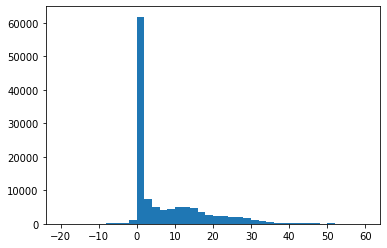

In [ ]:
# Target Distribution (before filter)

plt.hist(data_unf['bps'], bins=40, range=(-20,60))
plt.show()

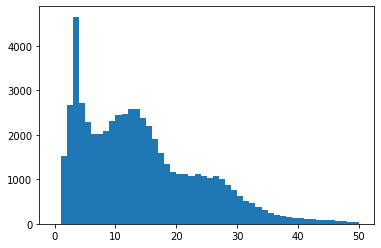

In [ ]:
# Target Distribution (after filter)

plt.hist(data['bps'], bins=50,range=(0,50))
plt.show()

In [ ]:
# # Distribution and Scatter Plots - Execute only the first time to save image

# sns_plot = sns.pairplot(data[plot_cols], height=2, diag_kind='kde')

# sns_plot.savefig(pathname+"/pairplot3.png")
# plt.clf()

<Figure size 1872x1872 with 0 Axes>

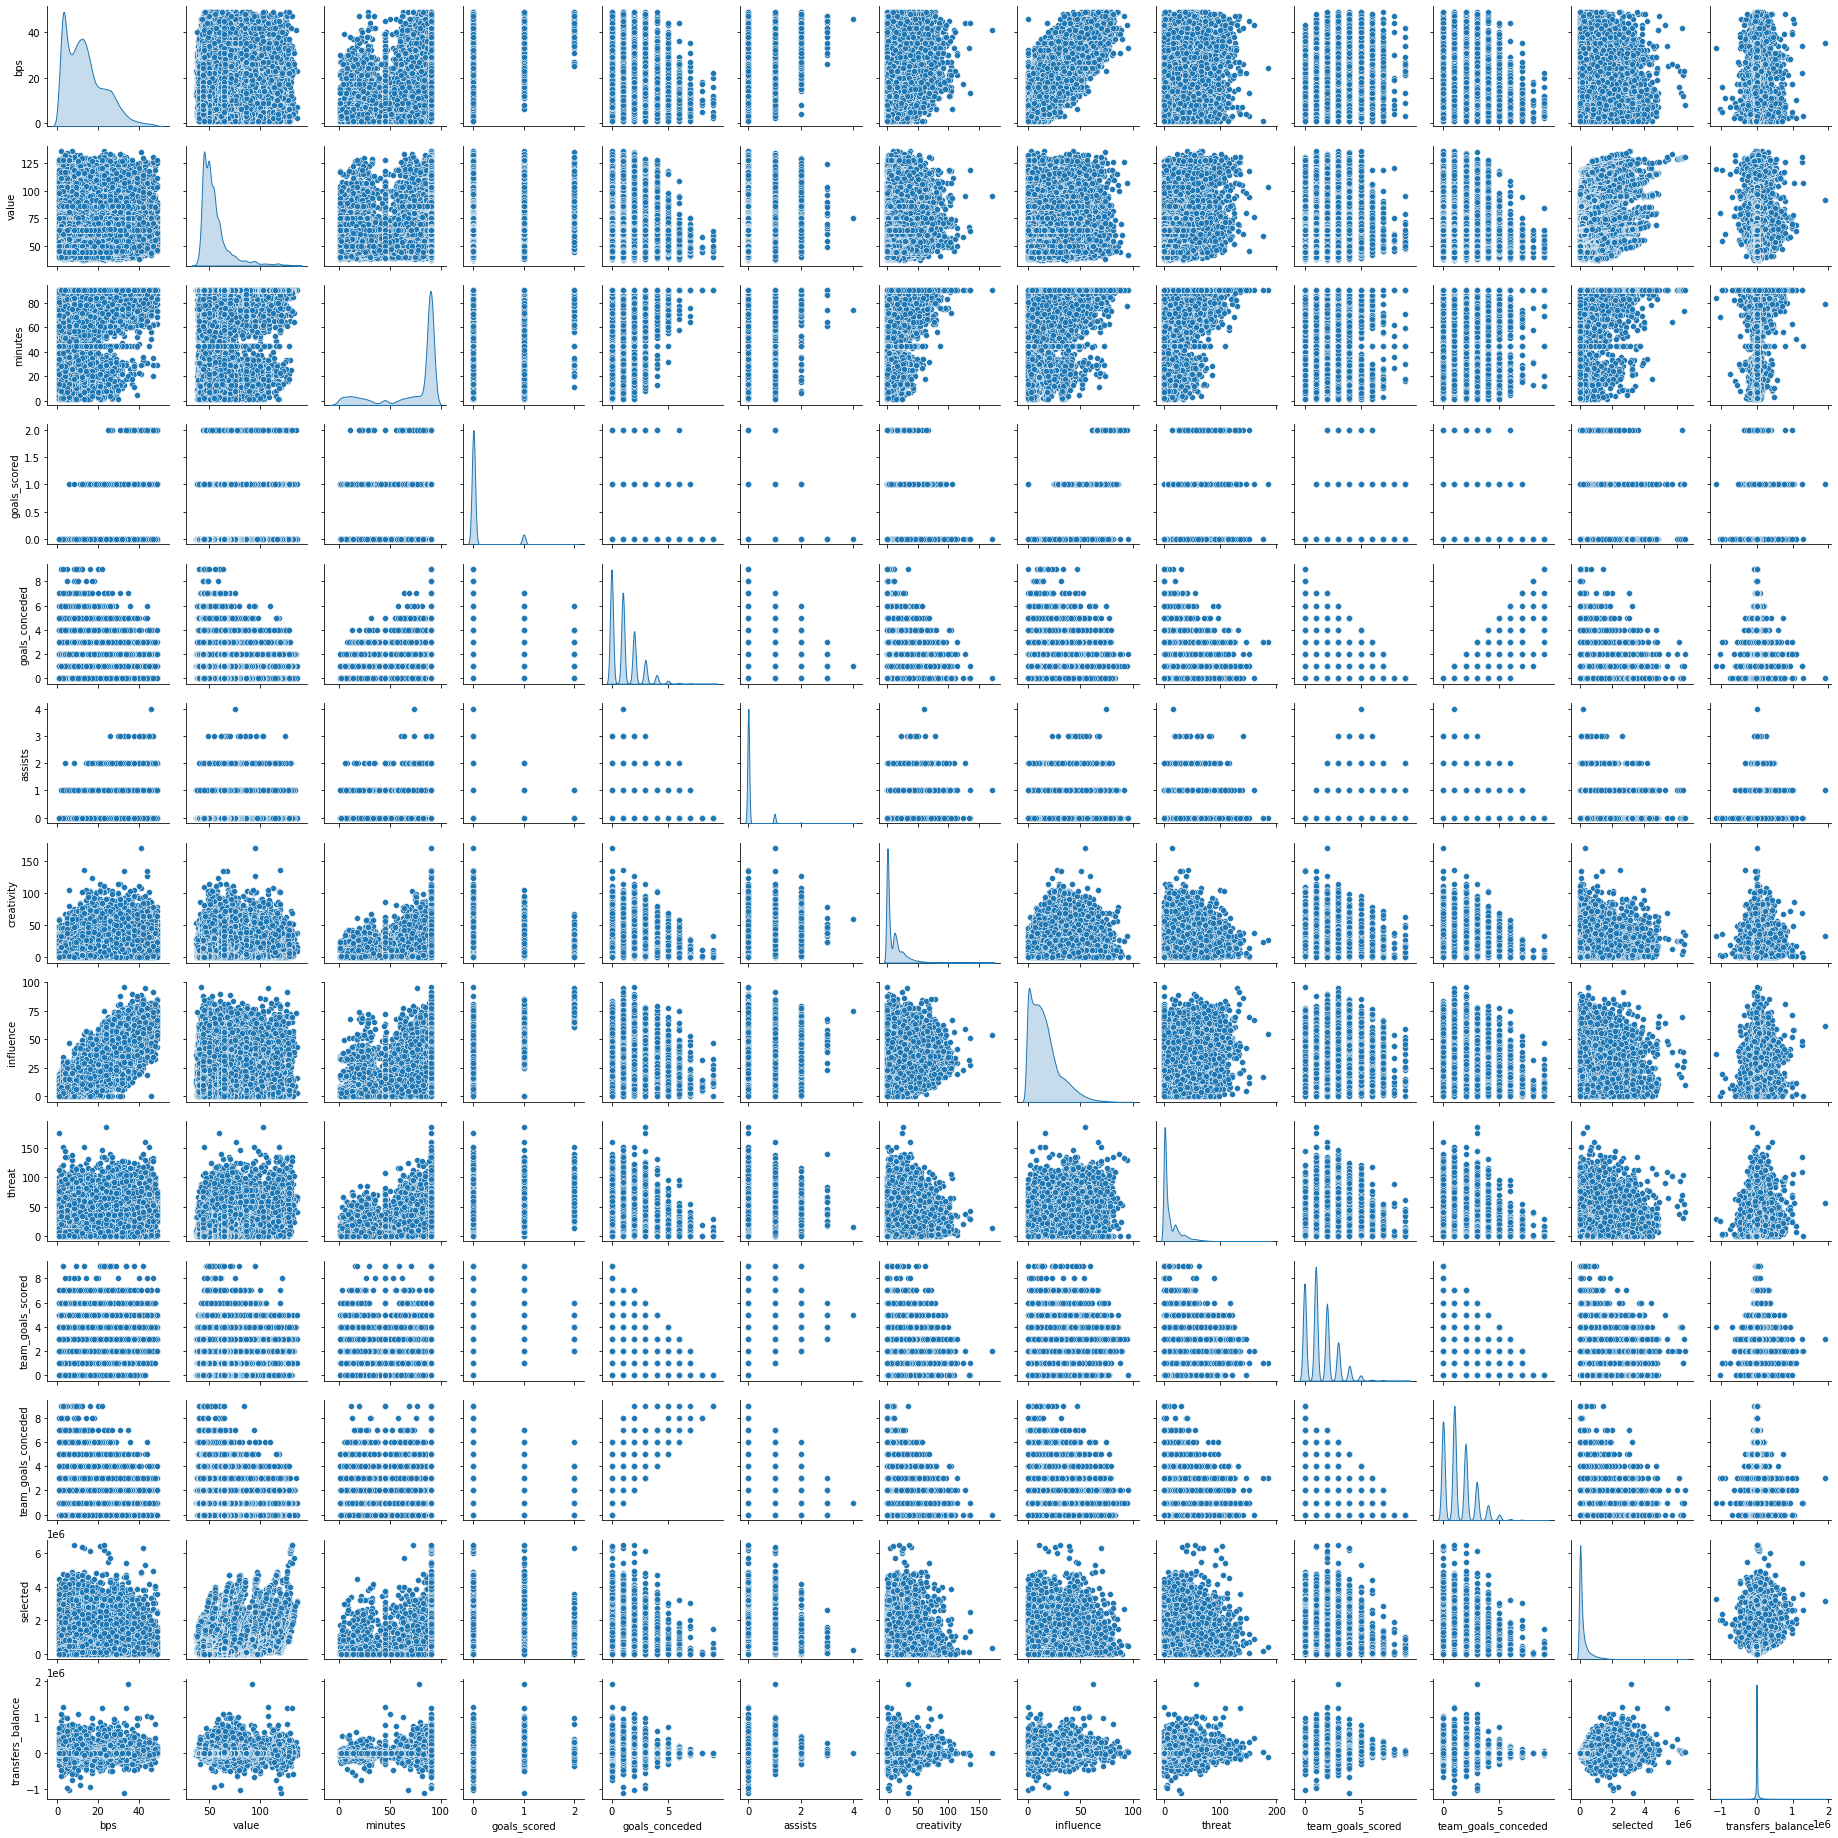

In [ ]:
# Distribution and Scatter Plots

# Loads image since plot generation code takes long to execute

Image(filename=pathname+"/pairplot3.png")

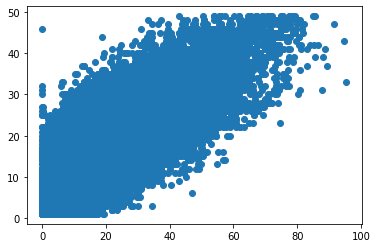

In [ ]:
# Scatter Plot of bps and influence

plt.scatter(data['influence'], data['bps'])

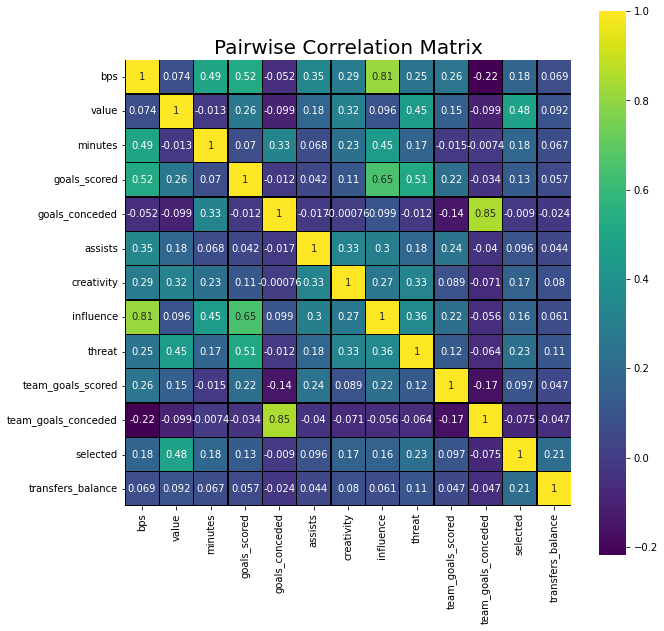

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(data[plot_cols].corr(),linewidths=0.5, square=True, cmap =plt.cm.viridis, linecolor='black', annot=True, ax=ax)
plt.title('Pairwise Correlation Matrix',fontsize=20)
plt.show()

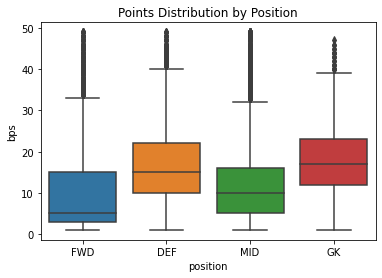

In [ ]:
sns.boxplot(data=data, x='position', y='bps')
plt.title('Points Distribution by Position',fontsize=12)
plt.show()

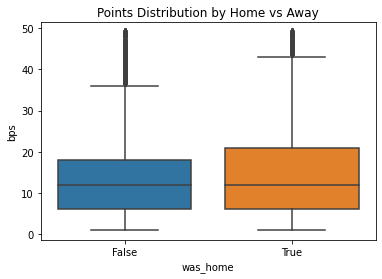

In [ ]:
sns.boxplot(data=data, x='was_home', y='bps')
plt.title('Points Distribution by Home vs Away',fontsize=12)
plt.show()

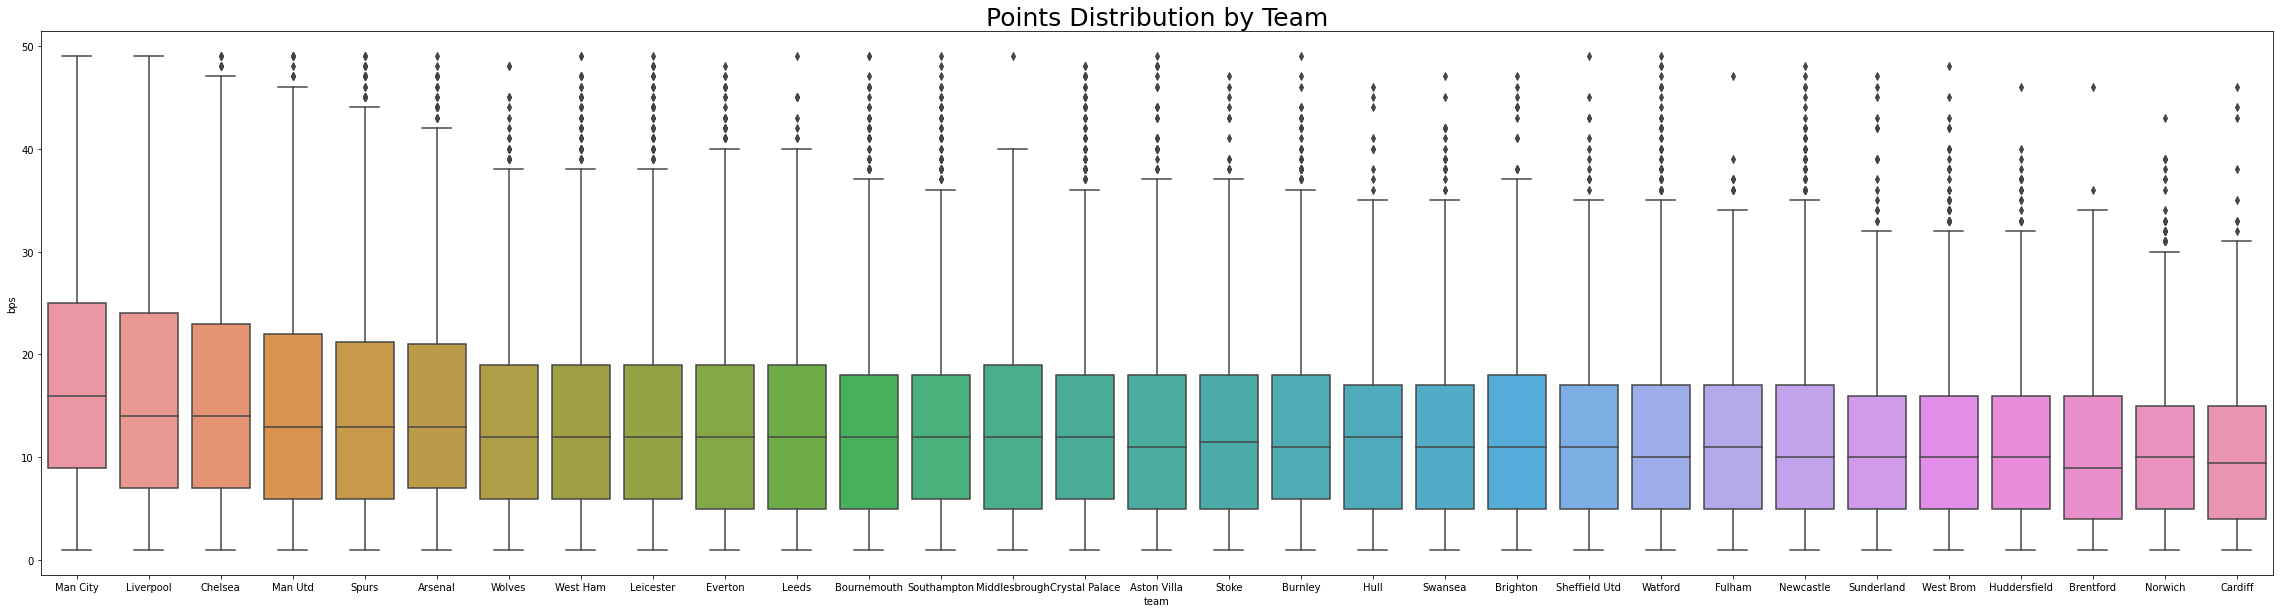

In [ ]:
fig, ax = plt.subplots(figsize=(40,10))
ranks = data.groupby('team')["bps"].mean().sort_values()[::-1].index
sns.boxplot(data=data, x='team', y='bps', ax=ax, order=ranks)
plt.title('Points Distribution by Team',fontsize=25)
plt.show()


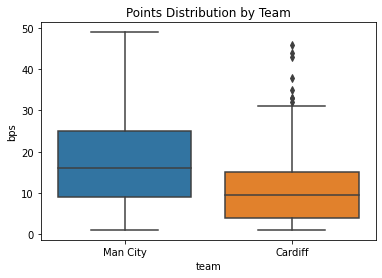

In [ ]:
sub_data = data[(data.team=='Man City') | (data.team=='Cardiff')].reset_index(drop=True)
sns.boxplot(data=sub_data, x='team', y='bps')
plt.title('Points Distribution by Team',fontsize=12)
plt.show()


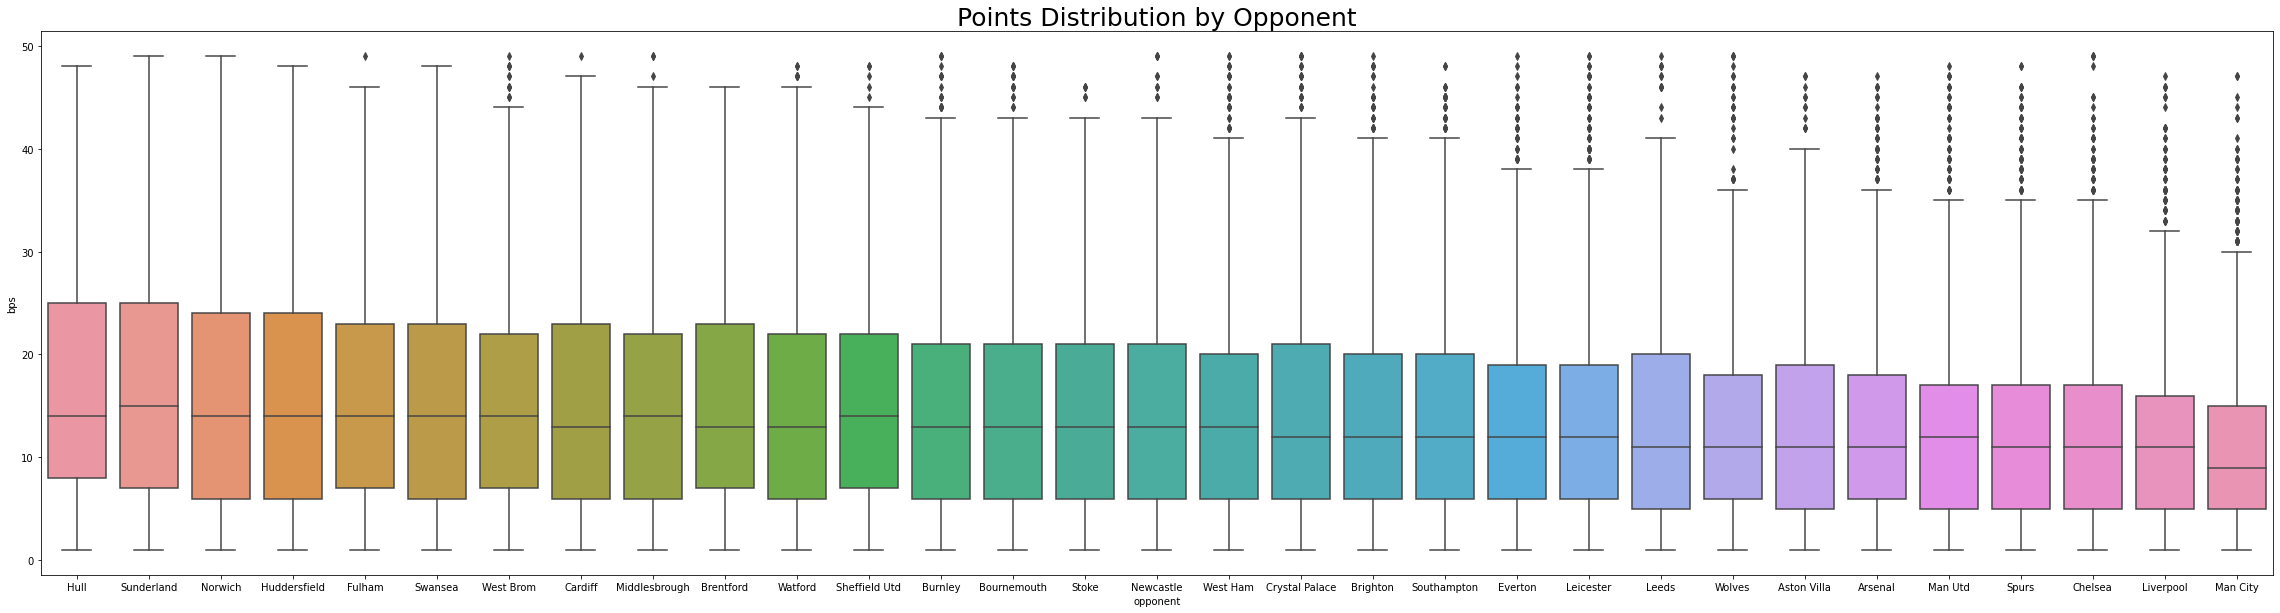

In [ ]:
fig, ax = plt.subplots(figsize=(40,10))
ranks = data.groupby('opponent')["bps"].mean().sort_values()[::-1].index
sns.boxplot(data=data, x='opponent', y='bps', ax=ax, order=ranks)
plt.title('Points Distribution by Opponent',fontsize=25)
plt.show()

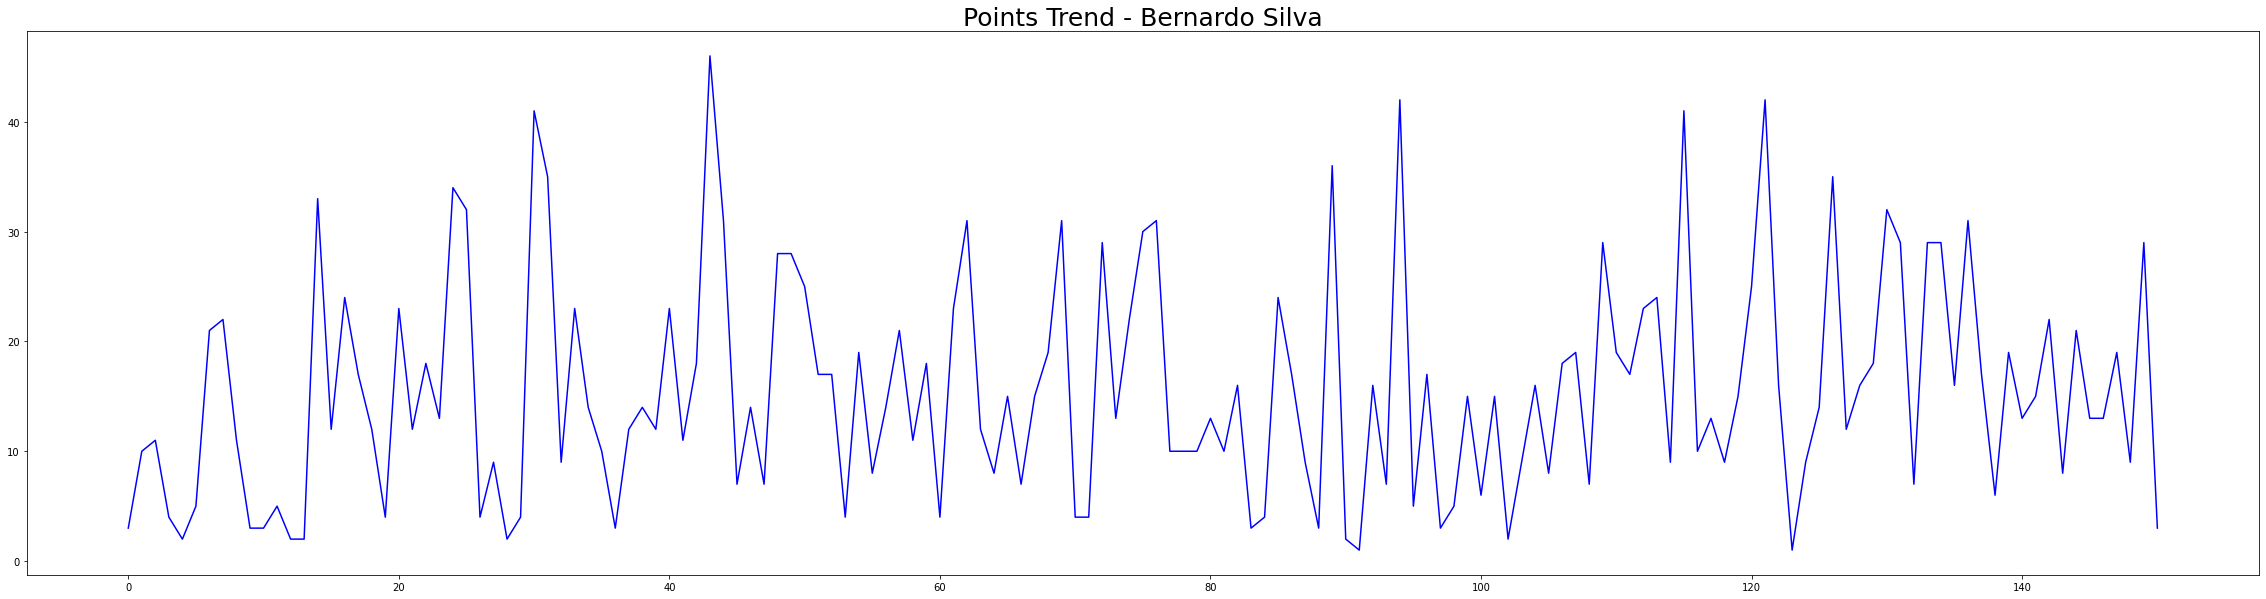

In [ ]:
plt.figure(figsize=(40,10))
player_data = data[(data.name == 'Bernardo Silva') & (data.bps>0)].reset_index(drop=True)
plt.plot(player_data['bps'], color='blue') #player_data['kickoff_time'].str[2:10], 
plt.title('Points Trend - Bernardo Silva',fontsize=25)
plt.show()

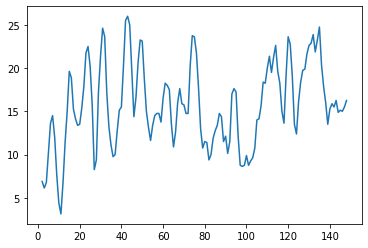

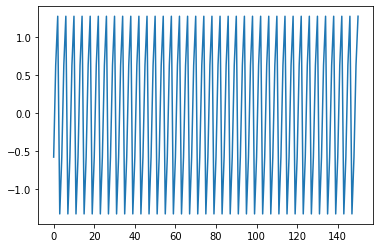

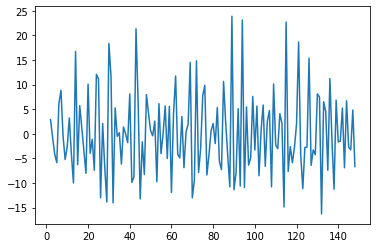

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(player_data['bps'], model='additive',freq=4)
plt.plot(result.trend)
plt.show()
plt.plot(result.seasonal)
plt.show()
plt.plot(result.resid)
plt.show()